<a href="https://colab.research.google.com/github/Frankl1sales/AWS-Sagemaker-Intelligent-Stock-Forecast/blob/main/LeNet_Albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install albumentations

In [24]:
!pip install tensorflow

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
print("TensorFlow version:", tf.__version__)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import os
import csv
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

TensorFlow version: 2.17.0


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
Label for 0-th train image is: 5


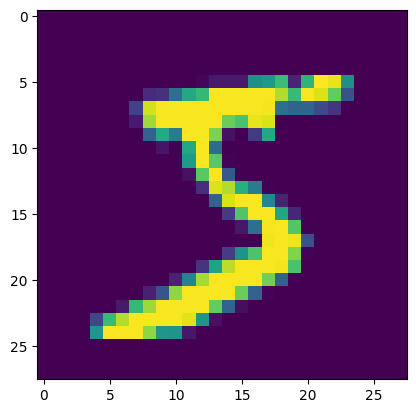

This is the native 0-th train label: 5
This is the one-hot encoding of the 0-th train label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.1085 - loss: 2.3081 - val_accuracy: 0.1125 - val_loss: 2.2999
Epoch 2/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.1070 - loss: 2.3036 - val_accuracy: 0.1227 - val_loss: 2.2971
Epoch 3/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.1047 - loss: 2.3031 - val_accuracy: 0.1085 - val_loss: 2.2995
Epoch 4/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.1069 - loss: 2.3029 - val_accuracy: 0.1163 - val_loss: 2.2988
Epoch 5/5
877/924 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.1082 - loss: 2.3031

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

imageIndex = 0
print("Label for " + str(imageIndex) + "-th train image is: " + str(train_labels[0]))
plt.imshow(train_images[0])
plt.show()

# Guardar uma cópia dos labels originais
ori_test_labels = copy.deepcopy(test_labels)

# One-hot encoding dos labels
imageIndex = 0
print("This is the native " + str(imageIndex) + "-th train label: " + str(train_labels[0]))
train_labels = to_categorical(train_labels)
print("This is the one-hot encoding of the " + str(imageIndex) + "-th train label: " + str(train_labels[0]))
test_labels = to_categorical(test_labels)

# Redimensionar as imagens para incluir o canal de cores (1 canal para grayscale)
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

# Normalizar as imagens para terem média zero e desvio unitário
train_mean = train_images.mean()
train_std = train_images.std()

train_images = (train_images - train_mean) / train_std
test_images = (test_images - train_mean) / train_std

# Definir as transformações de augmentação usando albumentations
augmentations = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    ToTensorV2()
])

# Function to apply augmentation
def augment_data(images, labels):
    augmenter = ImageDataGenerator(
        rotation_range=10,  # Rotating randomly the images up to 10°
        width_shift_range=0.05,  # Moving the images from left to right
        height_shift_range=0.05,  # Then from top to bottom
        shear_range=0.10,
        zoom_range=0.05,  # Zooming randomly up to 5%
        zca_whitening=False,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
    )

    # Convert the images to the correct data type
    images = images.astype(np.float32)

    # Apply augmentation
    augmented_images = []
    augmented_labels = []
    for i in range(len(images)):
        img = images[i]
        label = labels[i]
        img = augmenter.random_transform(img)
        augmented_images.append(img)
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Apply the augmentation to the training set
train_images, train_labels = augment_data(train_images, train_labels)

# Normalize the augmented images (if necessary)
train_images = (train_images - train_mean) / train_std

# Definir a arquitetura do modelo
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)
kernel_size = (5, 5)
num_kernel_first_conv_layer = 6
num_kernel_second_conv_layer = 16

model = Sequential()

model.add(Conv2D(num_kernel_first_conv_layer, kernel_size, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(num_kernel_second_conv_layer, kernel_size, padding='same'))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# Definir o otimizador
optimizer = tf.optimizers.SGD(learning_rate=1e-2)

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinar o modelo
BATCH_SIZE = 65
EPOCHS = 5
batch_history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))

# Avaliar o modelo
result = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {result[1]}')

# Plotar as curvas de perda e acurácia
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Perda
axs[0].plot(batch_history.history['loss'], label='Perda de Treinamento')
axs[0].plot(batch_history.history['val_loss'], label='Perda de Validação')
axs[0].set_title('Função de Perda/ Model Loss')
axs[0].set_xlabel('Épocas/Epoch')
axs[0].set_ylabel('Perda/Loss')
axs[0].legend(['train', 'test'], loc='upper right')

# Acurácia
axs[1].plot(batch_history.history['accuracy'], label='Acurácia de Treinamento')
axs[1].plot(batch_history.history['val_accuracy'], label='Acurácia de Validação')
axs[1].set_title('Acurácia/Accuracy')
axs[1].set_xlabel('Épocas/Epoch')
axs[1].set_ylabel('Acurácia/Accuracy')
axs[1].legend(['train', 'test'], loc='lower right')

plt.show()

# Matriz de confusão
predictions = model.predict(test_images)
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

# Salvar o modelo e informações adicionais
save_dir = os.path.join(os.getcwd(), 'trained_lenet5_mnist')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'model.keras'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Salvar média e desvio padrão como CSV
model_name = 'std_dev.csv'
model_path = os.path.join(save_dir, model_name)
w = csv.writer(open(model_path, "w"))
dict = {'mean': train_mean, 'std': train_std}
for key, val in dict.items():
    w.writerow([key, val])
print('Saved side information at %s ' % model_path)

# Plotar a distribuição dos labels originais
plt.figure(figsize=(10,5))
datas = pd.DataFrame(ori_test_labels, columns=['label'])
sns.countplot(x='label', data=datas)
plt.title('Distribution of labels in training set')
plt.show()